Есть датасет с непрерывной переменной. В нём содержатся контрольные значения и тестовые (экспериментальные).
Задача: сравнить группы bootstrap-способом (отдельно для среднего и медианы) и с помощью U-критерия Манна-Уитни.

In [18]:
import pandas as pd
import numpy as np
from scipy.stats import norm, mannwhitneyu
import seaborn as sns
import matplotlib.pyplot as plt

#from tqdm.auto import tqdm - прогресс-бар

plt.style.use('ggplot')

In [11]:
# Прочтём датасет с учётом разделителя и сразу удалим лишнюю колонку
df = pd.read_csv('hw_bootstrap.csv', sep=';').drop(columns=['Unnamed: 0'])

In [12]:
df.head()

,value,experimentVariant
0,"10,3804953740268",Control
1,"9,54686666784264",Control
2,"11,0882146509904",Control
3,"10,1472740570122",Control
4,"9,78980767524929",Control


In [13]:
df.dtypes

value                object
experimentVariant    object
dtype: object

In [14]:
# Преобразовуем value в численный тип данных
df.value = df.value.str.replace(',', '.')
df = df.astype({"value": "float"})
df.dtypes

value                float64
experimentVariant     object
dtype: object

In [15]:
df.experimentVariant.value_counts()

Treatment    500
Control      500
Name: experimentVariant, dtype: int64

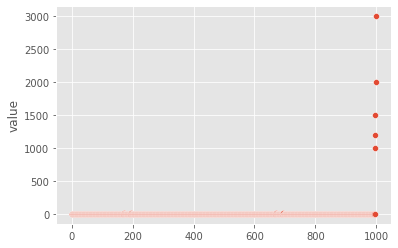

In [83]:
# Диаграмма рассеяния указывает на наличие выбросов 
# (что наряду с отклонением от нормального распределения (ниже) обуславливает применение критерия Манна-Уитни)
# Наличие экстремальных значений также обуславливает использование медианы как показателя, характеризующего
# центральную тенденцию
sns.scatterplot(data=df.value)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


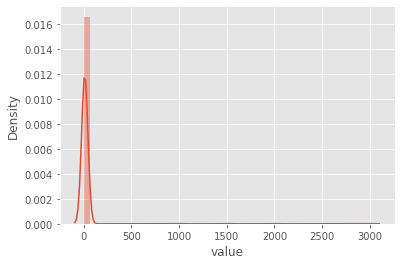

In [84]:
sns.distplot(df.value)

In [27]:
control_row = df[df.experimentVariant == 'Control'].value
treatment_row = df[df.experimentVariant == 'Treatment'].value

In [50]:
def get_bootstrap(
    data_column_1,
    data_column_2,
    boot_it = 1000,
    statistic = np.mean,
    bootstrap_conf_level = 0.95
):
# Собираем распределение статистического параметра
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in range(boot_it):
        samples_1 = data_column_1.sample(boot_len, replace=True).values
        samples_2 = data_column_2.sample(boot_len, replace=True).values
        boot_data.append(statistic(samples_1 - samples_2))
        
    pd_boot_data = pd.DataFrame(boot_data)
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
    
    p_1 = norm.cdf(x=0, loc=np.mean(boot_data), scale = np.std(boot_data))
    p_2 = norm.cdf(x=0, loc=-np.mean(boot_data), scale = np.std(boot_data))
    p_value = min(p_1, p_2) * 2
    
    #plt.hist(pd_boot_data[0], bins=50)
    
    #plt.style.use('ggplot')
    #plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
    #plt.xlabel('boot_data')
    #plt.ylabel('frequency')
    #plt.title("Histogram of boot_data")
    #plt.show()
    
    return {"boot_data": boot_data,
            "ci": ci,
            "p_value": p_value}

In [51]:
mean_boot = get_bootstrap(control_row, treatment_row, boot_it=1000)

In [52]:
print(f'Доверительный интервал: ci = {mean_boot["ci"]},\np_value = {mean_boot["p_value"]}')

Доверительный интервал: ci =                0
0.025 -34.323554
0.975  -2.978516,
p_value = 0.03751988436931902


In [53]:
median_boot = get_bootstrap(control_row, treatment_row, boot_it=1000, statistic=np.median)

In [54]:
print(f'Доверительный интервал: ci = {median_boot["ci"]},\np_value = {median_boot["p_value"]}')

Доверительный интервал: ci =               0
0.025 -0.157697
0.975  0.124356,
p_value = 0.84613708382962


In [55]:
mannwhitneyu(control_row, treatment_row)

MannwhitneyuResult(statistic=124189.5, pvalue=0.8592148582485579)

In [64]:
print(f'Boot_mean: {mean_boot["p_value"]} Boot_median: {median_boot["p_value"]}\
 MW: {mannwhitneyu(control_row, treatment_row).pvalue}')

Boot_mean: 0.03751988436931902 Boot_median: 0.84613708382962 MW: 0.8592148582485579


In [65]:
# Для минимизации случайных факторов проведём бутстрап 10 раз
for i in range(10):
    mean_boot = get_bootstrap(control_row, treatment_row, boot_it=1000)
    median_boot = get_bootstrap(control_row, treatment_row, boot_it=1000, statistic=np.median)
    print(f'Boot_mean: {mean_boot["p_value"]} Boot_median: {median_boot["p_value"]}\
 MW: {mannwhitneyu(control_row, treatment_row).pvalue}')

Boot_mean: 0.039411065142156254 Boot_median: 0.9211117795785101 MW: 0.8592148582485579
Boot_mean: 0.04029187273492872 Boot_median: 0.9013724716955902 MW: 0.8592148582485579
Boot_mean: 0.03770668557201398 Boot_median: 0.8332625038698089 MW: 0.8592148582485579
Boot_mean: 0.036076455579720515 Boot_median: 0.8945789271068968 MW: 0.8592148582485579
Boot_mean: 0.044643526248487886 Boot_median: 0.8837756629974545 MW: 0.8592148582485579
Boot_mean: 0.03360608913873422 Boot_median: 0.8877406328512458 MW: 0.8592148582485579
Boot_mean: 0.04004299320184837 Boot_median: 0.9121050067972252 MW: 0.8592148582485579
Boot_mean: 0.0407766722330718 Boot_median: 0.8895862880971148 MW: 0.8592148582485579
Boot_mean: 0.04211621176770904 Boot_median: 0.8552091650790816 MW: 0.8592148582485579
Boot_mean: 0.04743099602198906 Boot_median: 0.8623213544185542 MW: 0.8592148582485579


In [ ]:
# Значения p-value при бутстрапе для медианы "схожи" со значениями p-value 
# по критерию Манна-Уитни (переводит переменные в ранговые), при этом это значение показывает,
# что мы не можем отклонить нулевую гипотезу, т.е. различий в распределениях переменных между контрольной и
# тестовой выборкой нет.